# Models Work

In [40]:
! rm -r project_chd/

In [41]:
! git clone https://github.com/JulianKrese/project_chd/

Cloning into 'project_chd'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 88 (delta 12), reused 8 (delta 8), pack-reused 69
Receiving objects: 100% (88/88), 2.60 MiB | 24.02 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from graphviz import Source

In [43]:
# getting training sets
X_train = pd.read_csv("/content/project_chd/X_train_cleaned.csv")
y_train = pd.read_csv("/content/project_chd/y_train_cleaned.csv")

# getting test sets
X_test = pd.read_csv("/content/project_chd/X_test_cleaned.csv")
y_test = pd.read_csv("/content/project_chd/y_test_cleaned.csv")

In [44]:
# keep track of all R-squared values found
R_squared_vals = {}

kNN R^2: 0.8478334119549835
best k:  1


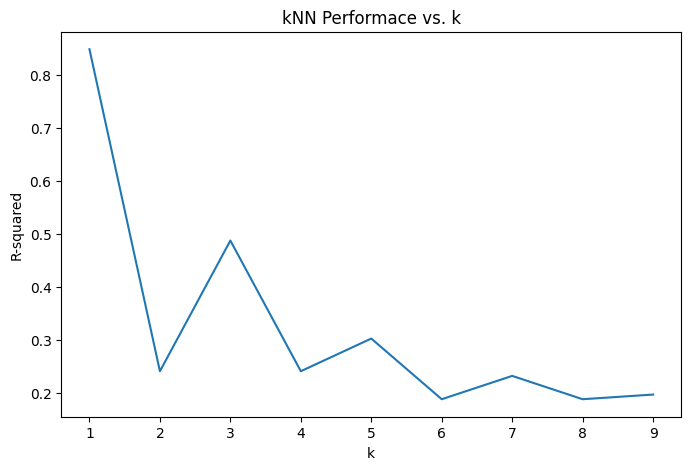

col_0    0   1
row_0         
0      685  96
1      114  19


In [66]:
# Create kNN model - k of 1 gives the highest R-squared
best_k = 0
best_r2 = 0
r2_scores = []
ks = list(range(1,10))
for k in ks:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train.values.ravel()) # .values.ravel() suppresses data conversion warning - converts column vector to 1d array
  y_pred = knn.predict(X_test)
  r2 = abs(r2_score(y_test, y_pred))
  r2_scores.append(r2)
  if r2 > best_r2:
    best_r2 = r2
    best_k = k

print("kNN R^2:", best_r2)
print("best k: ", best_k)
R_squared_vals["kNN"] = best_r2

#  Visualizing R-squared vs. k
plt.figure(figsize=(8, 5))
plt.plot(ks, r2_scores)
plt.xlabel('k')
plt.ylabel('R-squared')
plt.title('kNN Performace vs. k')
plt.show()


# Confusion matrix:
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train.values.ravel())
y_pred_best = best_knn.predict(X_test)

y_test_flat = np.ravel(y_test) # Flatten the arrays
y_pred_best_flat = np.ravel(y_pred_best)

cross_tab = pd.crosstab(y_test_flat, y_pred_best_flat)
print(cross_tab)

# lots of false negatives (bottom left)

Decision tree R^2: 0.8742310321257691
Best depth 24


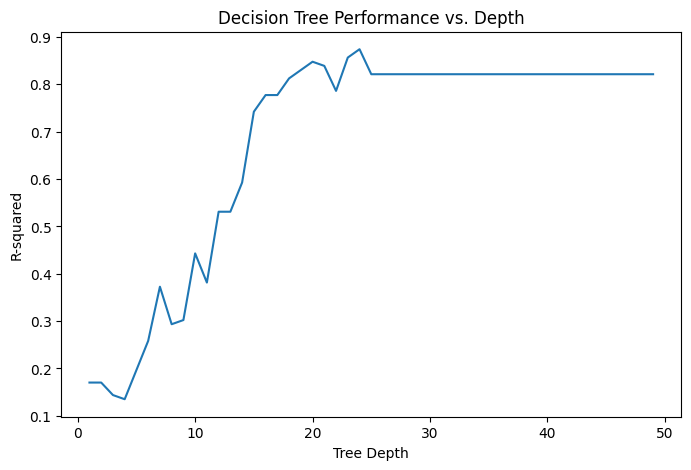

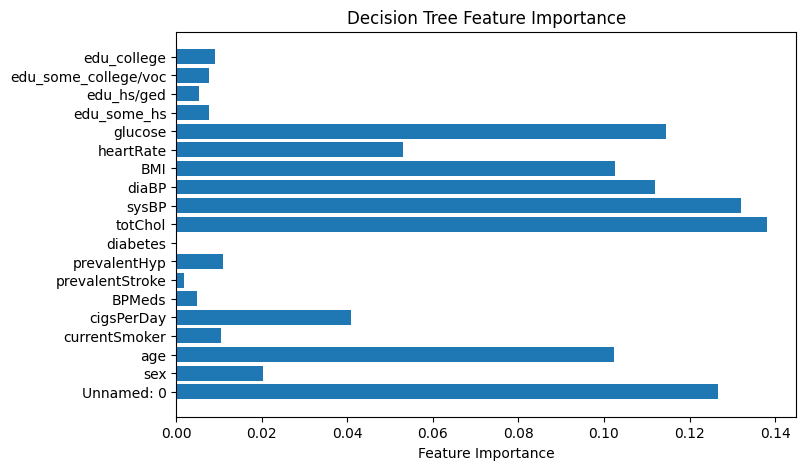

col_0    0    1
row_0          
0      664  117
1       96   37


In [65]:
# Create decision tree - depth of 24 gives the highest R-squared
best_depth = 0
best_r2 = 0
depths = list(range(1, 50))
r2_scores = []
for d in depths:
  dt = DecisionTreeClassifier(max_depth=d, random_state=42)
  dt.fit(X_train, y_train)
  y_pred = dt.predict(X_test)
  r2 = abs(r2_score(y_test, y_pred))
  r2_scores.append(r2)
  if r2 > best_r2:
    best_r2 = r2
    best_depth = d

print("Decision tree R^2:", best_r2)
print("Best depth", best_depth)
R_squared_vals["Decision tree"] = best_r2

#  Visualizing R-squared vs. Tree Depth
plt.figure(figsize=(8, 5))
plt.plot(depths, r2_scores)
plt.xlabel('Tree Depth')
plt.ylabel('R-squared')
plt.title('Decision Tree Performance vs. Depth')
plt.show()

# Visualizing which features are the most important
dt = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt.fit(X_train, y_train)
importances = dt.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importance')
plt.show()

# confusion matrix
y_pred_best = dt.predict(X_test)
y_test_flat = np.ravel(y_test) # Flatten the arrays
y_pred_best_flat = np.ravel(y_pred_best)
cross_tab = pd.crosstab(y_test_flat, y_pred_best_flat)
print(cross_tab)

# lots of false positives (top right)
# confusion matrix for dt is not much better compared to knn
# dt still better at capturing variation in data due to higher R^2

In [47]:
# trying linear regression with all variables
stock_reg = LinearRegression().fit(X_train, y_train)
r2 = abs(stock_reg.score(X_test, y_test))
print("R^2 (all variables) = ", r2)
R_squared_vals["Linear regression"] = r2

R^2 (all variables) =  0.09069686607234828


In [48]:
# trying linear regression with min-max normalizing
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
norm_reg = LinearRegression().fit(X_train_norm, y_train)
r2 = abs(norm_reg.score(X_test_norm, y_test))
print("R^2 (min-max normalized): ", r2)
R_squared_vals["Max-min normalized"] = r2

R^2 (min-max normalized):  0.09069686607234895


R^2 (correlated vars on prevalentHyp): 0.06374168477694897


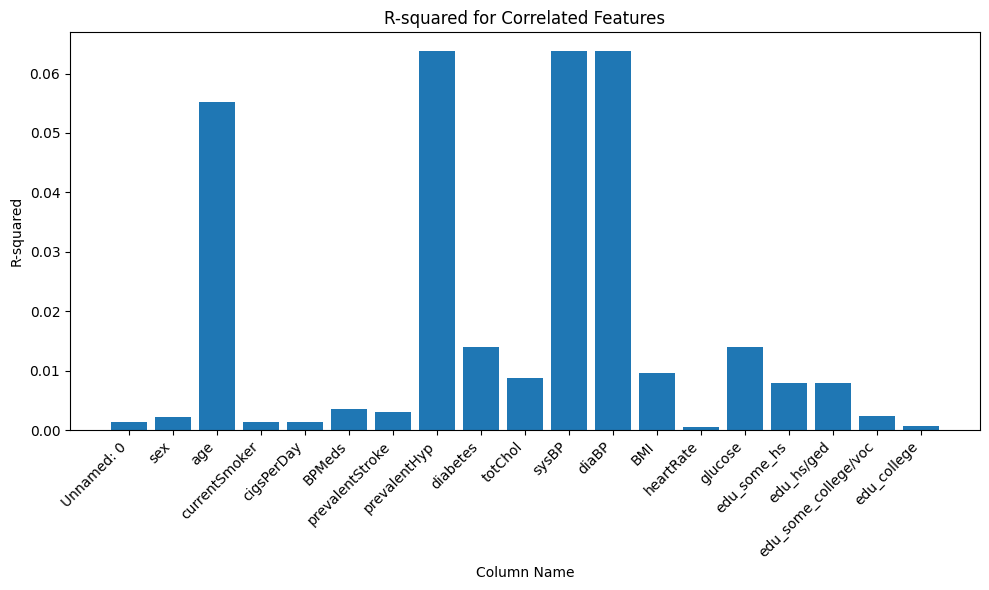

In [49]:
# trying linear regression with different correlated variables (finds col w/ highest R-squared)
corr_matrix = X_train.corr()
best_r2 = 0
best_col = ""
r2_scores = []
cols = []
for col in corr_matrix:
  high_corr_vars = corr_matrix.index[abs(corr_matrix[col]) > 0.5]
  X_train_corr = X_train[high_corr_vars]
  X_test_corr = X_test[high_corr_vars]
  corr_reg = LinearRegression().fit(X_train_corr, y_train)
  r2 = abs(corr_reg.score(X_test_corr, y_test))
  r2_scores.append(r2)
  cols.append(col)
  if r2 > best_r2:
    best_r2 = r2
    best_col = col

print(f"R^2 (correlated vars on {best_col}): {best_r2}")
R_squared_vals[f"Correlated vars on {best_col}"] = best_r2

#  Visualizing R-squared vs. Column
plt.figure(figsize=(10, 6))
plt.bar(cols, r2_scores)
plt.xlabel('Column Name')
plt.ylabel('R-squared')
plt.title('R-squared for Correlated Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

R^2 (polynomial features, degree=1):  0.09069686607234839


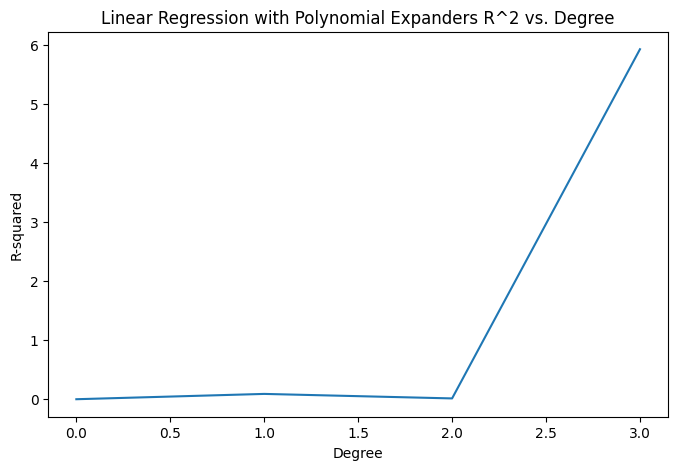

In [50]:
# trying linear regression with polynomial expanders (tests multiple degrees to find best R-squared)
best_r2 = 0
best_degree = 0
degrees = list(range(0,4))
r2_scores = []
for d in degrees:
  poly = PolynomialFeatures(degree=d)
  X_train_poly = poly.fit_transform(X_train)
  X_test_poly = poly.transform(X_test)
  poly_reg = LinearRegression().fit(X_train_poly, y_train)
  r2 = abs(poly_reg.score(X_test_poly, y_test))
  r2_scores.append(r2)
  if (r2 > best_r2) and (r2 <= 1):
    best_r2 = r2
    best_degree = d

print(f"R^2 (polynomial features, degree={best_degree}): ", best_r2)
R_squared_vals["Polynomial expanders"] = best_r2

#  Visualizing R-squared vs. Degrees
plt.figure(figsize=(8, 5))
plt.plot(degrees, r2_scores)
plt.xlabel('Degree')
plt.ylabel('R-squared')
plt.title('Linear Regression with Polynomial Expanders R^2 vs. Degree')
plt.show()

In [51]:
# print all R-squared vals found
print(R_squared_vals)

{'kNN': 0.8478334119549835, 'Decision tree': 0.8742310321257691, 'Linear regression': 0.09069686607234828, 'Max-min normalized': 0.09069686607234895, 'Correlated vars on prevalentHyp': 0.06374168477694897, 'Polynomial expanders': 0.09069686607234839}


In [52]:
# find max
max(R_squared_vals.items(), key=lambda k: k[1])

('Decision tree', 0.8742310321257691)

It appears that the most effective form of predictive algorithm is the Decision Tree Classifier, with the R^2 value coming out to be 0.87 after training at a max depth of 24.